## 第7章 ファクター・モデルの応用

### 7.1 資本コストの推定

#### 7.1.2 FF3モデルによる株式資本コストの推定

In [1]:
# ch07_01: 外部パッケージの読み込みとデータの準備

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# seabornのバージョンによっては，将来の仕様変更に関する警告が発せられるため，それを非表示に
import warnings
warnings.filterwarnings("ignore")

monthly_data = pd.read_csv("ch05_output1.csv")
annual_data = pd.read_csv("ch05_output2.csv")
factor_data = pd.read_csv("ch06_output.csv")

# 2020年の年末時点で上場しているかフラグ付け
monthly_data['is_public_2020'] = monthly_data.groupby('firm_ID')['month_ID'].transform(
    lambda x: max(x) == 72
)

# 各firm_IDのデータ数をカウント
monthly_data['N_observations'] = monthly_data.groupby('firm_ID')['month_ID'].transform('count')

# 2020年の年末時点で上場しており，かつ，36ヶ月以上のデータがあるfirm_IDのみ抽出
monthly_data = monthly_data[
    (monthly_data['is_public_2020'] == True) & (monthly_data['N_observations'] >= 36)
]

# N_observations列を削除
monthly_data = monthly_data.drop(columns='N_observations') 

# annual_dataとmonthly_dataでyearとfirm_IDのペアを整合的に
annual_data = monthly_data[['year', 'firm_ID']].drop_duplicates().merge(
    annual_data, on=['year', 'firm_ID'], how='left'
)

In [2]:
# ch07_02: FF3モデルの推定 (1)

# 統計モデルを構築・分析するためのモジュールをインポート
import statsmodels.formula.api as smf

# firm_IDの固有要素を抽出してfirm_ID_setとして定義
firm_ID_set = monthly_data['firm_ID'].unique()

# R_Fはmonthly_dataとfactor_dataで重複するので削除
monthly_data = monthly_data.drop(columns='R_F') 

# factor_dataを結合
monthly_data = monthly_data.merge(factor_data, on='month_ID', how='outer') 

FF3_results = []  # 推定結果を保存するために空のリストを準備

# firm_IDの固有要素ごとにFF3モデルを推定
for each_firm in firm_ID_set:
    # 固有要素ごとにデータを抽出し，each_firm_dataに保存
    each_firm_data = monthly_data[monthly_data['firm_ID'] == each_firm] 
    
    # 冒頭に"0 +"を追加して定数項をゼロにしてFF3モデルを推定
    results = smf.ols('Re ~ 0 + R_Me + SMB + HML', data=each_firm_data).fit() 
    
    # 回帰結果をデータフレームdfとして保存
    df = results.summary2().tables[1]
    df['firm_ID'] = each_firm
    
    # 回帰結果を保存したdfをリストに代入
    FF3_results.append(df) 

# pandasのconcat()関数を使ってリストに入っているデータフレームを一つのデータフレームに統合
binded_FF3_results = pd.concat(FF3_results) 

# firm_ID列を先頭列に移動
binded_FF3_results = binded_FF3_results[
    ['firm_ID'] + [col for col in binded_FF3_results.columns if col != 'firm_ID']
] 

In [3]:
# ch07_03: FF3モデルの推定 (2)

# pivot()メソッドを使って，横長形式のデータフレームFF3_loadingsを作成
FF3_loadings = binded_FF3_results.reset_index().pivot(
    index='firm_ID', 
    columns='index', 
    values='Coef.'
).rename(
    columns={'R_Me': 'beta_M', 'SMB': 'beta_SMB', 'HML': 'beta_HML'}
).reset_index()

# pivot()関数は列をアルファベット順に自動的にソートするため， beta_M, beta_SMB, beta_HMLの順で改めてソート
FF3_loadings = FF3_loadings[['firm_ID', 'beta_M', 'beta_SMB', 'beta_HML']] 

In [4]:
# ch07_04: ファクター・リスクプレミアムの計算

factor_risk_premium = factor_data.iloc[:, 3:6].mean() * 12
factor_risk_premium = pd.DataFrame(factor_risk_premium).T

##        R_Me       SMB       HML
## 0  0.048005  0.078584  0.083282

In [5]:
# ch07_05: Fama-Frenchの3ファクター・モデルに基づいて株式資本コストを推定

# Fama-Frenchの3ファクター・モデルに基づいて期待リターンを計算
expected_R_FF3 = FF3_loadings.iloc[:, 1:4] @ factor_risk_premium.values.T  

# firm_IDとcost_of_capitalの二列から成るFF3_cost_of_capitalを作成
FF3_cost_of_capital = FF3_loadings[['firm_ID']].copy()
FF3_cost_of_capital['cost_of_capital'] = expected_R_FF3.values

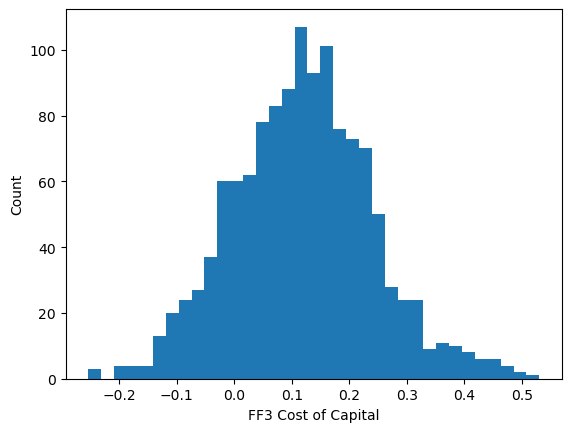

In [6]:
# ch07_06: 株式資本コストの推定値をヒストグラムで可視化

plt.hist(FF3_cost_of_capital['cost_of_capital'], bins=35)  # Rでのアウトプットに近付けるため，bins引数はautoとせず，35に設定
plt.xlabel('FF3 Cost of Capital')
plt.ylabel('Count')
plt.show()

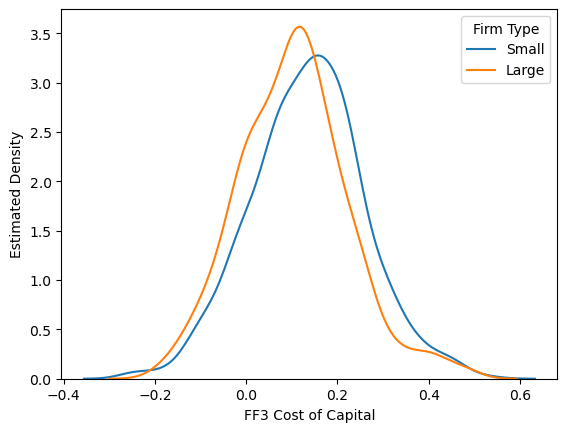

In [7]:
# ch07_07: 時価総額別に株式資本コストの推定値を可視化

# 企業ごとに時価総額を計算
annual_data['lagged_ME'] = annual_data.groupby('firm_ID')['ME'].shift(1)

# 2020年のデータのみ抽出
annual_data_2020 = annual_data[annual_data['year'] == 2020].copy()

# 時価総額に基づき二分割
annual_data_2020['ME_rank2'] = pd.qcut(annual_data_2020['lagged_ME'], 2, labels=['Small', 'Large'])

# 株式資本コストの推定値を追加
annual_data_2020 = annual_data_2020.merge(FF3_cost_of_capital, on='firm_ID')

# 欠損値を削除
annual_data_2020.dropna(inplace=True)

# プロット作成
for me_rank in ['Small', 'Large']:
    subset = annual_data_2020[annual_data_2020['ME_rank2'] == me_rank]
    sns.kdeplot(subset['cost_of_capital'], label=me_rank)
plt.xlabel('FF3 Cost of Capital')
plt.ylabel('Estimated Density')
plt.legend(title='Firm Type')
plt.show()

#### 7.1.3 株式資本コストの応用:潜在配当成長率の推定

In [8]:
# ch07_08: 配当利回りの計算

dividend_yield_2020 = monthly_data[monthly_data['year'] == 2020].groupby('firm_ID').apply(
    lambda x: pd.Series({
        'annual_dividend': (x['DPS'] * x['shares_outstanding']).sum(),  # 各月の配当支払総額を合計
        'latest_ME': x['ME'].iloc[-1]  # iloc[-1]によりfirm_IDごとに最新の時価総額を取得
    })
).reset_index()

# 配当利回りの実績値を計算
dividend_yield_2020['dividend_yield'] = dividend_yield_2020['annual_dividend'] / dividend_yield_2020['latest_ME'] 

# 無配の企業を落とす
dividend_yield_2020 = dividend_yield_2020[dividend_yield_2020['dividend_yield'] > 0] 

In [9]:
# ch07_09: 潜在配当成長率の推定

# 株式資本コストの推定値を追加
dividend_yield_2020 = dividend_yield_2020.merge(FF3_cost_of_capital, on='firm_ID', how='left')

# 配当割引モデルから潜在配当成長率を逆算
dividend_yield_2020['implied_dividend_growth'] = (
    (dividend_yield_2020['cost_of_capital'] - dividend_yield_2020['dividend_yield']) 
    / (1 + dividend_yield_2020['dividend_yield'])
)

### 7.2 平均分散ポートフォリオの構築

#### 7.2.2 分散共分散行列の推定

In [10]:
# ch07_10: ファクターの分散共分散行列の推定
Sigma_FF3 = 12 * factor_data.iloc[:, 3:6].cov()  # 12を掛けて年次データに換算

##           R_Me       SMB       HML
## R_Me  0.020686 -0.003902  0.001530
## SMB  -0.003902  0.006268 -0.001886
## HML   0.001530 -0.001886  0.003916

In [11]:
# ch07_11: 投資対象企業の選定

# 投資対象の企業を100社に限定
N_portfolio_firms = 100

# 2020年の中から時価総額の上位100社を選択
investment_universe = (
    annual_data[annual_data['year'] == 2020]
    .nlargest(N_portfolio_firms, 'ME')
    .sort_values('firm_ID')['firm_ID']
    .reset_index(drop=True)
)

## 0       33
## 1      101
## 2      155
## 3      167
## 4      204
##       ...
## 95    1400
## 96    1408
## 97    1454
## 98    1473
## 99    1499
## Name: firm_ID, Length: 100, dtype: int64

In [12]:
# ch07_12: 誤差項の分散共分散行列の推定

# monthly_dataから投資対象に含まれるデータのみ抽出
monthly_data = monthly_data[monthly_data['firm_ID'].isin(investment_universe)].merge(FF3_loadings, on='firm_ID')

# ファクターの実現値からFF3モデルに基づくリターンの計算
monthly_data['R_FF3'] = (
    monthly_data['R_F'] + 
    monthly_data['beta_M'] * monthly_data['R_Me'] + 
    monthly_data['beta_SMB'] * monthly_data['SMB'] + 
    monthly_data['beta_HML'] * monthly_data['HML']
)

# 実際のリターンとの違いから誤差項を推定
monthly_data['epsilon'] = monthly_data['R'] - monthly_data['R_FF3']

# firm_IDごとに誤差項の分散を推定
Sigma_epsilon = np.diag((12 * monthly_data.groupby('firm_ID')['epsilon'].var()).values)

In [13]:
# ch07_13: リターンの分散共分散行列を準備

beta = FF3_loadings[FF3_loadings['firm_ID'].isin(investment_universe)].drop('firm_ID', axis=1).values
Sigma = beta @ Sigma_FF3.values @ beta.T + Sigma_epsilon

In [14]:
# ch07_14: 期待リターンのベクトルを準備

mu = FF3_cost_of_capital.loc[FF3_cost_of_capital['firm_ID'].isin(investment_universe), 'cost_of_capital'].values

#### 7.2.3 平均分散ポートフォリオの計算

In [15]:
# ch07_15: cvxoptパッケージのインストール

# 必要に応じて，以下のコードなどを実行して，Rのquadprog相当のcvxoptをインストール
# !pip install cvxopt

# cvxoptを読み込み
import cvxopt
from cvxopt import matrix
from cvxopt.solvers import qp

In [16]:
# ch07_16: qp()関数を利用した平均分散ポートフォリオの計算 (1)

# 目標期待リターンを0.1に設定
target_return = 0.1

# 引数の定義は公式サイト参照 (https://cvxopt.org/userguide/coneprog.html#quadratic-programming)
P = matrix(Sigma)
q = matrix(np.zeros_like(mu))
G = matrix(np.zeros_like(mu)).T
h = matrix(0.0)
A = matrix(np.column_stack((mu, np.ones_like(mu)))).T
b = matrix(np.array([target_return, 1.0]))

MV_portfolio = qp(P, q, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0:  3.5037e-03  3.5037e-03  1e+00  1e+00  4e-17
 1:  3.5037e-03  3.5037e-03  1e-02  1e-02  4e-17
 2:  3.5037e-03  3.5037e-03  1e-04  1e-04  3e-17
 3:  3.5037e-03  3.5037e-03  1e-06  1e-06  3e-17
 4:  3.5037e-03  3.5037e-03  1e-08  1e-08  3e-17
Optimal solution found.


In [17]:
# ch07_17: qp()関数を利用した平均分散ポートフォリオの計算 (2)

# qp()関数の返り値は辞書型のため，辞書のキーを確認
print(MV_portfolio.keys())

## dict_keys(['x', 'y', 's', 'z', 'status', 'gap', 'relative gap', 'primal objective', 'dual objective', 
## 'primal infeasibility', 'dual infeasibility', 'primal slack', 'dual slack', 'iterations'])

dict_keys(['x', 'y', 's', 'z', 'status', 'gap', 'relative gap', 'primal objective', 'dual objective', 'primal infeasibility', 'dual infeasibility', 'primal slack', 'dual slack', 'iterations'])


In [18]:
# ch07_18: qp()関数を利用した平均分散ポートフォリオの計算 (3)

# 最適保有比率を保存して，最初の10社だけ表示
optimal_weight = MV_portfolio["x"]
print(optimal_weight[0:10])

## [ 5.81e-02]
## [ 2.45e-02]
## [ 1.21e-02]
## [-2.71e-02]
## [ 1.24e-02]
## [-1.70e-01]
## [ 1.19e-02]
## [ 1.29e-02]
## [ 5.18e-02]
## [-1.11e-02]

# 平均分散ポートフォリオのリスクを保存して表示
minimized_risk = np.sqrt(2 * MV_portfolio["primal objective"])
print(minimized_risk)

## 0.08371002833427407

[ 5.81e-02]
[ 2.45e-02]
[ 1.21e-02]
[-2.71e-02]
[ 1.24e-02]
[-1.70e-01]
[ 1.19e-02]
[ 1.29e-02]
[ 5.18e-02]
[-1.11e-02]

0.08371002833427406


#### 7.2.4 平均分散フロンティアの描画

In [19]:
# ch07_19: 平均分散ポートフォリオの描画 (1)

# -0.1から0.4の範囲を離散化して目標期待リターンを100次元のベクトルで準備
target_returns = np.linspace(-0.1, 0.4, 100)

# 平均分散ポートフォリオのリスクを保存するための空リストを準備
minimized_risks = []

# ソルバーの進行状況表示をオフに設定
cvxopt.solvers.options['show_progress'] = False

# 目標リターンごとに最小リスクを計算
for each_target_return in target_returns:
    # 制約条件の設定
    b = matrix(np.array([each_target_return, 1.0]))
    
    # 最適化問題の解決
    MV_portfolio = qp(P, q, G, h, A, b)
    
    # 最小化されたリスクの計算とリストへの追加
    minimized_risks.append(np.sqrt(2 * MV_portfolio['primal objective']))

# リスク値のリストをNumPy配列に変換
minimized_risks = np.array(minimized_risks)

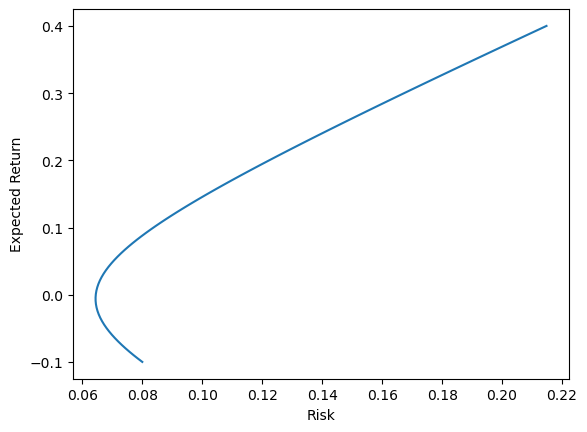

In [20]:
# ch07_20: 平均分散ポートフォリオの描画 (2)

MV_frontier = pd.DataFrame({'target_returns': target_returns, 'minimized_risks': minimized_risks})

# MV_frontierをMatplotlibを用いて描画
plt.plot(MV_frontier['minimized_risks'], MV_frontier['target_returns'])
plt.xlabel('Risk')
plt.ylabel('Expected Return')
plt.show()

In [21]:
# 以上のコードについて，動作確認をした実行環境の表示
# 本セルは，実行環境の確認のためであり，無視してもらっても構わない
import session_info
session_info.show(dependencies=False)